## Perceptron

In [1]:
# import some required libraries.
import pylab
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import os
import gzip

# pick the seed for reproducability - change it to explore the effects of random variations
np.random.seed(1)
import random

### Toy Problem

#### generate a random classification dataset

In [2]:
n = 50
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0)
Y = Y*2-1 # convert initial 0/1 values into -1/1
X = X.astype(np.float32)
Y = Y.astype(np.int32) # features - float, label - int

# Split the dataset into training and test
train_x, test_x = np.split(X, [ n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])
print("Features:\n",train_x[0:4])
print("Labels:\n",train_labels[0:4])

Features:
 [[-1.7441838  -1.3952037 ]
 [ 2.5921783  -0.08124504]
 [ 0.9218062   0.91789985]
 [-0.8437018  -0.18738253]]
Labels:
 [-1 -1  1 -1]


####  plot the dataset:

C:\Users\lvgy\AppData\Local\Temp\ipykernel_22128\2696701706.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


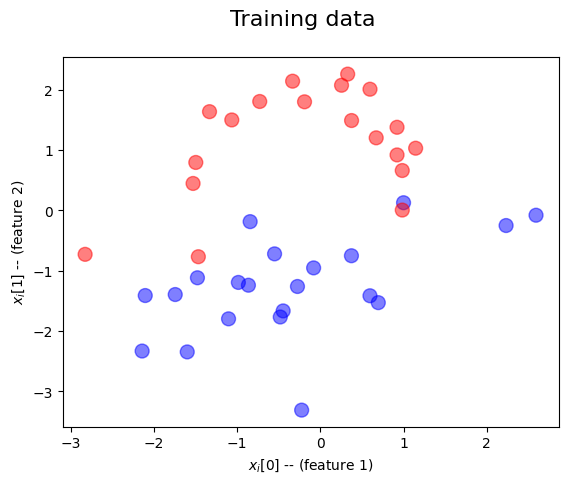

In [3]:
def plot_dataset(suptitle, features, labels):
    # prepare the plot
    fig, ax = pylab.subplots(1, 1)
    #pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l>0 else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

plot_dataset('Training data', train_x, train_labels)

####  To simplify the model

In [4]:
pos_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x)
                          if train_labels[i]>0])
neg_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x)
                          if train_labels[i]<0])
# print(pos_examples[0:3])

[[ 0.92180622  0.91789985  1.        ]
 [-1.06435513  1.49764717  1.        ]
 [ 0.32839951  2.25677919  1.        ]]


In [25]:
# num_dims = pos_examples.shape[1]
# # print(pos_examples.shape)
# # print(num_dims)
# weights = np.zeros((num_dims,1))
# # print(weights)
# pos = random.choice(pos_examples)
# print(pos)
# weights = weights + pos.reshape(weights.shape)
# print(pos.reshape(weights.shape))
# aa = np.array([1, 1])
# bb = np.array([2, 2])
# print(aa + bb)

[3 3]


#### define the Algorithm

In [5]:
def train(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]

    # Initialize weights.
    # We initialize with 0 for simplicity, but random initialization is also a good idea
    weights = np.zeros((num_dims,1))

    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]

    report_frequency = 10

    for i in range(num_iterations):
        # Pick one positive and one negative example
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)
        if z < 0: # positive example was classified as negative
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0: # negative example was classified as positive
            weights = weights - neg.reshape(weights.shape)

        # Periodically, print out the current accuracy on all examples
        if i % report_frequency == 0:
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            print("Iteration={}, pos correct={}, neg correct={}".format(i,pos_correct,neg_correct))

    return weights

#### run the training

In [21]:
wts = train(pos_examples,neg_examples)
print(wts.transpose())

Iteration=0, pos correct=0.7368421052631579, neg correct=1.0
Iteration=10, pos correct=0.7894736842105263, neg correct=0.8095238095238095
Iteration=20, pos correct=0.8421052631578947, neg correct=0.5238095238095238
Iteration=30, pos correct=0.8947368421052632, neg correct=1.0
Iteration=40, pos correct=0.8421052631578947, neg correct=0.9523809523809523
Iteration=50, pos correct=0.8947368421052632, neg correct=0.9047619047619048
Iteration=60, pos correct=0.9473684210526315, neg correct=0.9523809523809523
Iteration=70, pos correct=0.8947368421052632, neg correct=1.0
Iteration=80, pos correct=0.7894736842105263, neg correct=0.8095238095238095
Iteration=90, pos correct=0.9473684210526315, neg correct=0.9523809523809523
[[-1.8608771   3.50343032  1.        ]]


#### plot the class separation line

In [22]:
def plot_boundary(positive_examples, negative_examples, weights):
    if np.isclose(weights[1], 0):
        if np.isclose(weights[0], 0):
            x = y = np.array([-6, 6], dtype = 'float32')
        else:
            y = np.array([-6, 6], dtype='float32')
            x = -(weights[1] * y + weights[2])/weights[0]
    else:
        x = np.array([-6, 6], dtype='float32')
        y = -(weights[0] * x + weights[2])/weights[1]

    pylab.xlim(-6, 6)
    pylab.ylim(-6, 6)
    pylab.plot(positive_examples[:,0], positive_examples[:,1], 'bo')
    pylab.plot(negative_examples[:,0], negative_examples[:,1], 'ro')
    pylab.plot(x, y, 'g', linewidth=2.0)
    pylab.show()

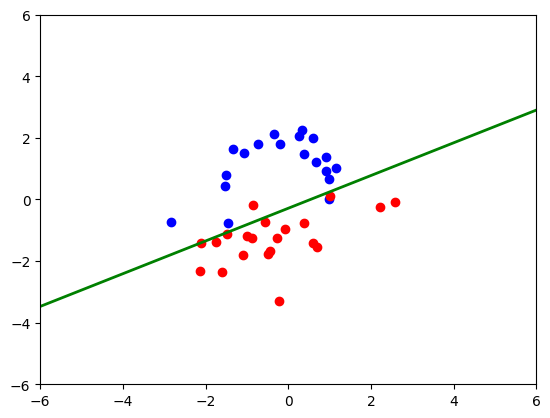

In [23]:
plot_boundary(pos_examples,neg_examples,wts)

#### Evaluate on Test Dataset

In [39]:
# aug_x = np.c_[test_x, np.ones(len(test_x))]
# print("test_labels.shape: ", test_labels.shape)
# print("test_labels: ", test_labels)
# print("aug_x: ", aug_x)
# res = np.dot(aug_x, wts)
# print("res: ", res)
# print("res.shape: ", res.reshape(test_labels.shape) )

test_labels.shape:  (10,)
test_labels:  [-1 -1  1 -1  1 -1  1  1  1  1]
aug_x:  [[-0.94381231 -1.53997076  1.        ]
 [ 0.86847043 -0.58612704  1.        ]
 [-0.43362409  1.4454633   1.        ]
 [ 1.82183111 -2.10919023  1.        ]
 [ 0.04765327  1.93680012  1.        ]
 [ 0.25428766 -0.84713876  1.        ]
 [ 1.50196433  0.76893359  1.        ]
 [-2.57367945  0.26153296  1.        ]
 [-0.24031815  1.81169462  1.        ]
 [-0.65619886  1.0485127   1.        ]]
res:  [[-2.63886152]
 [-2.66957199]
 [ 6.87100109]
 [-9.77960479]
 [ 7.6967674 ]
 [-2.44108971]
 [ 0.89893424]
 [ 6.70556367]
 [ 7.79434842]
 [ 5.89449661]]
res.shape:  [-2.63886152 -2.66957199  6.87100109 -9.77960479  7.6967674  -2.44108971
  0.89893424  6.70556367  7.79434842  5.89449661]


In [28]:
def accuracy(weights, test_x, test_labels):
    # 1️⃣ Append a bias-feature 1 to every test point
    aug_x = np.c_[test_x, np.ones(len(test_x))]        # shape (n, d+1)

    # 2️⃣ Raw scores (signed distances) of the linear model
    res = np.dot(aug_x, weights)                       # shape (n,) or (n,1)

    # 3️⃣ Count how many signs match the labels ( +1 / –1 )
    correct = (res.reshape(test_labels.shape) * test_labels >= 0).sum()

    # 4️⃣ Return fraction correct
    return correct / float(len(test_labels))

In [29]:
accuracy(wts, test_x, test_labels)

np.float64(1.0)

#### Visualize Observing the training process

In [41]:
def train_graph(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]
    weights = np.zeros((num_dims,1)) # initialize weights

    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]

    report_frequency = 15;
    snapshots = []

    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)
        if z < 0:
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0:
            weights = weights - neg.reshape(weights.shape)

        if i % report_frequency == 0:
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            # make correction a list so it is homogeneous to weights list then numpy array accepts
            snapshots.append((np.concatenate(weights),[(pos_correct+neg_correct)/2.0,0,0]))

    return np.array(snapshots)

snapshots = train_graph(pos_examples,neg_examples)

def plotit(pos_examples,neg_examples,snapshots,step):
    fig = pylab.figure(figsize=(10,4))
    fig.add_subplot(1, 2, 1)
    plot_boundary(pos_examples, neg_examples, snapshots[step][0])
    fig.add_subplot(1, 2, 2)
    pylab.plot(np.arange(len(snapshots[:,1])), snapshots[:,1])
    pylab.ylabel('Accuracy')
    pylab.xlabel('Iteration')
    pylab.plot(step, snapshots[step,1][0], "bo")
    pylab.show()
def pl1(step): plotit(pos_examples,neg_examples,snapshots,step)

In [42]:
interact(pl1, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))


interactive(children=(IntSlider(value=0, description='step', max=6), Output()), _dom_classes=('widget-interact…

<function __main__.pl1(step)>

### Limitations of the Perceptron

In [43]:
pos_examples_xor = np.array([[1,0,1],[0,1,1]])
neg_examples_xor = np.array([[1,1,1],[0,0,1]])

snapshots_xor = train_graph(pos_examples_xor,neg_examples_xor,1000)
def pl2(step): plotit(pos_examples_xor,neg_examples_xor,snapshots_xor,step)

In [44]:
interact(pl2, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))


interactive(children=(IntSlider(value=0, description='step', max=6), Output()), _dom_classes=('widget-interact…

<function __main__.pl2(step)>